# [Run 1.2i] Using the LSST Stack tools to do positional matching on coadd and src catalogs
<br>Owner: **Ji Won Park** ([@jiwoncpark](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jiwoncpark)) modified a similar notebook for Run 1.1p written by **Jim Chiang** ([@jchiang87](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@jchiang87)).
<br>Created: **2019-02-27**
<br> Last Run: **2019-04-18**

**Note:** 
- This notebook reflects some schema changes that went into effect from Run 1.2i and, correspondingly, Generation 2 of Butler. If you're interested in Run 1.1p, go to Jim's original notebook [here](https://nbviewer.jupyter.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_stack.nbconvert.ipynb) instead.
- I also added some more annotations to guide DM beginners like me! They were mostly taken from function docstrings in [daf-persistence source code](https://github.com/lsst/daf_persistence) and [lsst skymap source code](https://github.com/lsst/skymap).

In this notebook, we use the data butler to retrieve catalogs from coadd and visit-level analyses of Run 1.2i, and use the `lsst.afw.table.matchRaDec` function to do positional matching against galaxy truth info extracted from the protoDC2 extragalactic catalog v3.0, on which Run 1.2i was based.

## Set Up

In [1]:
import warnings
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
from lsst.geom import radians
import lsst.daf.persistence as dp
import GCRCatalogs

%matplotlib inline

## Load a subset of the truth catalog

We said we wanted to match the "observed" objects in the Run 1.2i coadd and visit-level catalogs to the "truth (input)" objects in the protoDC2 catalog. The inconvenience with working directly with protoDC2, however, is that we need to first rotate its field to the Run 1.2i field in order to compare the positions. To bypass this step, we match Run 1.2i to the truth catalog instead of the protoDC2 catalog. If we wanted to retrieve the protoDC2 column information, we would simply join the truth catalog with the protoDC2 catalog based on the keys, `object_id` for the former and `galaxy_id` for the latter.

We will download a small portion of the truth catalog and see which of the input objects we "observe" in the Run 1.2i coadd and visit-level catalogs.

In [2]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    truth_gcr = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')

We query the brightest objects, as they are more likely to be matched, by thresholding their r-band magnitudes. For speed purposes, we also downselect the sky region to an area that correspond to the subset of visit-level/coadd catalogs we will use in this tutorial.

In [3]:
our_bp = 'r' # bandpass we'll use to query the brightest objects
max_mag = 24.5
brightest = '{} < {}'.format(our_bp, max_mag)
within_region = ['ra < 56.2', 'ra > 55.8', 'dec < -28.4', 'dec > -28.85']
truth_cols = ['object_id', 'ra', 'dec', 'r']
truth_dict = truth_gcr.get_quantities(truth_cols, native_filters=[brightest,], filters=within_region)
truth_df = pd.DataFrame(truth_dict)
print(truth_df.shape)

(7429, 4)


To use the positional matching code `lsst.afw.table.matchRaDec` mentioned above, `dict` or `pandas.DataFrame`-type catalogs won't do. We actually need to get our truth catalog in the `lsst.afw.table` format:

In [4]:
def make_afw_table(bands=['r',]):
    """Initializes an afw table with magnitude column(s)"""
    def define_mag_columns(bands):
        """Defines columns for given list of bands"""
        Coldef = namedtuple('Coldef', 'name type doc'.split())
        return [Coldef('mag_{}'.format(bp), float, '{}-magnitude'.format(bp)) for bp in bands]
    # Some minimal schema
    schema = afw_table.SourceTable.makeMinimalSchema()
    # Define magnitude columns
    mag_cols = define_mag_columns(bands=bands)
    # Add magnitude columns to schema
    for mag_coldef in mag_cols:
        schema.addField(mag_coldef.name, type=mag_coldef.type, doc=mag_coldef.doc)
    return afw_table.SourceCatalog(schema)

truth_afw = make_afw_table(bands=['r',])
for id_, ra_, dec_, mag_ in zip(*[truth_dict[col] for col in truth_cols]):
    row = truth_afw.addNew()
    row.set('id', id_)
    row.set('coord_ra', afw_geom.Angle(ra_, afw_geom.degrees))
    row.set('coord_dec', afw_geom.Angle(dec_, afw_geom.degrees))
    row.set('mag_{}'.format(our_bp), mag_)

## Matching Experiments

Now that we have the tools we need, let's read in the Run 1.2i DRP catalog data.

We first instantiate our Butler object. Butler manages a collection of datasets known as a "repository." Each dataset has a `datasetType` identified by strings such as `'src'` or `'calexp'`.

In [5]:
# Create data butlers for the src and coadd repositories.
repo_path = '/global/cscratch1/sd/desc/DC2/data/Run1.2i_globus_in2p3_20181217/w_2018_39/rerun/multiband'
butler = dp.Butler(repo_path)

### Sources or Objects?

We can consider visit-level src catalog data, in which case we would define `datasetType='src'` and provide a query, or `dataId`, to the butler with (`visit`, `raftName`, `sensorName`) ids; or we can consider coadd object data, for which we would define `datasetType='coadd'` and provide a `dataId` with (`filter`, `tract`, `patch`) ids.

Somewhat different flux models are available in the Run1.2i data for src catalogs versus coadd catalogs. We use `'base_PsfFlux'` for the flux model, as they are available in both.

Let's start with the visit-level src catalog data. We first double-check the key definitions for the src catalog, as they change across run versions. (For example, we identified rafts with `raft` in Run 1.1p but now use `raftName`.)

### Fetching the src catalog

In [6]:
# As mentioned above, here are the keys you can use to query the src catalog
butler.getKeys(datasetType='src')

{'visit': int,
 'filter': str,
 'raftName': str,
 'detectorName': str,
 'detector': int}

We'll now define a set of pre-selected IDs that uniquely defines a dataset. (Note: to check that some combination of data IDs corresponds to an available dataset, we can call `datasetExists()` on each `dataRef` object.)

In [7]:
our_visit = 219976
our_raftName = 'R20'
our_detector = 80

our_dataId_src = {'visit': our_visit, 'filter': our_bp, 'raftName': our_raftName, 'detector': our_detector,}

The following function fetches the ID, ra, dec, and calibrated r-band magnitude of the visit-level/coadd catalog and saves the information in an afw table. 
It also does some querying to get objects that are (1) extended, (2) primary (no children), (3) not flux-flagged, and (4) bright. Galaxies can be selected as extended objects (or sources) using the `base_ClassificationExtendedness_value`. We use the model flag and flux to ensure that a flux value could be measured, and then apply a selection to ensure that we get deblended objects. Finally, we apply a relatively bright magnitude cut, to avoid confusion when performing the positional match.

In [8]:
def get_drp_catalog(butler, data_type, dataId):
    """Given a DRP dataset type and the dataId, 
    returns a afw table of the corresponding DRP catalog"""
    if data_type=='src':
        catalog_type = 'src'
        calexp_type = 'calexp'
    elif data_type=='obj':
        catalog_type = 'deepCoadd_meas'
        calexp_type = 'deepCoadd'
    # Get the catalog for the given dataId
    catalog = butler.get(datasetType=catalog_type, dataId=dataId)
    # For calibration
    calexp = butler.get(datasetType=calexp_type, dataId=dataId)
    calib = calexp.getCalib()
    calib.setThrowOnNegativeFlux(False)
    # Filter is r for our purposes, but we can get it this way too
    observed_filter = calexp.getInfo().getFilter().getName()
    # Get primary extended objects with no flux flag
    flux_model = 'base_PsfFlux' # schema v3
    model_flux = catalog.get(flux_model + '_instFlux')
    model_flag = catalog.get(flux_model + '_flag')
    extendedness = catalog.get('base_ClassificationExtendedness_value')
    num_children = catalog.get('deblend_nChild')
    queried = catalog.subset((extendedness == 1) &\
                             (model_flag == False) &\
                             (model_flux > 0) &\
                             (num_children == 0))
    # Extract the magnitude and further apply the depth cut
    mag = calib.getMagnitude(queried[flux_model + '_instFlux'])
    queried = queried.subset(mag < max_mag)
    # Create the afw table of our catalog
    drp_catalog = make_afw_table(bands=['r',]) # initialize
    for row in queried:
        new_rec = drp_catalog.addNew()
        for name in 'id coord_ra coord_dec parent'.split():
            new_rec.set(name, row[name])
        new_rec.set('mag_{}'.format(observed_filter),
                    calib.getMagnitude(row[flux_model + '_instFlux']))
    return drp_catalog

How many sources do we have?

In [9]:
drp_src_catalog = get_drp_catalog(butler=butler, data_type='src', dataId=our_dataId_src)
len(drp_src_catalog)

718

### Fetching the coadd catalog

Similarly, let's fetch the coadd object data.

In [10]:
# Get which keys are available
butler.getKeys(datasetType='deepCoadd_meas')

{'filter': str, 'tract': int, 'patch': str}

We would like to find a tract & patch combination that overlaps in sky area with the src catalog we just made. To do so, we fetch the `deepCoadd_skyMap` object and pass the four extreme corner coordinates of our src catalog to `findTractPatchList`.

In [12]:
skymap = butler.get(datasetType='deepCoadd_skyMap', dataId=our_dataId_src)

# radians
min_ra, max_ra = np.min(drp_src_catalog['coord_ra']), np.max(drp_src_catalog['coord_ra'])
min_dec, max_dec = np.min(drp_src_catalog['coord_dec']), np.max(drp_src_catalog['coord_dec'])

coord_list = [
    afw_geom.SpherePoint(min_ra * radians, min_dec * radians),
    afw_geom.SpherePoint(max_ra * radians, min_dec * radians),
    afw_geom.SpherePoint(max_ra * radians, max_dec * radians),
    afw_geom.SpherePoint(min_ra * radians, max_dec * radians),
]

# This will be a list of tracts that overlap
# Each tract entry will have its own list of patches that overlap
tract_patches = skymap.findTractPatchList(coord_list)
for tract, patches in tract_patches:
    for patch in patches:
        print(tract.getId(), patch.getIndex())

4850 (0, 4)
4850 (0, 5)
4850 (1, 4)
4850 (1, 5)
4850 (2, 4)
4850 (2, 5)


Great! Let us arbitrarily choose patch (1, 5).

In [14]:
our_tract = 4850
our_patch = '1,5' # Note the formatting! String with no space after the comma.

our_dataId_obj = {'filter': our_bp, 'tract': our_tract, 'patch': our_patch,}

Now we can fetch our coadd catalog and turn it into an afw table. How many objects do we have?

In [15]:
drp_obj_catalog = get_drp_catalog(butler=butler, data_type='obj', dataId=our_dataId_obj)
len(drp_obj_catalog)

866

### Doing the Matching
We can now carry out the spatial matching, and compute some quantities to plot. You can switch between `drp_obj_catalog` and `drp_src_catalog` to see the difference in matching between the coadd and src catalogs.

In [16]:
# Find positional matches within 100 milliarcseconds:
matching_radius = afw_geom.Angle(0.1, afw_geom.arcseconds)
src_matches = afw_table.matchRaDec(drp_src_catalog, truth_afw, matching_radius)
obj_matches = afw_table.matchRaDec(drp_obj_catalog, truth_afw, matching_radius)
print(len(obj_matches), len(src_matches))

852 587


`matches` is a list of `match` objects, each one containing an observed-true matchd galaxy pair. The code below shows how to work with these, looping over the matches and extracting information to plot.

In [17]:
def compare_differences(drp_catalog, matches, observed_filter):
    num_matches = len(matches)    
    # Compare magnitudes for matched objects:
    drp_mag = np.zeros(num_matches, dtype=np.float)
    truth_mag = np.zeros(num_matches, dtype=np.float)
    sep = np.zeros(num_matches, dtype=np.float)
    # Arrays for a quiver plot.
    u = np.zeros(num_matches, dtype=np.float)
    v = np.zeros(num_matches, dtype=np.float)
    for i, match in enumerate(matches):
        drp_mag[i] = match.first['mag_{}'.format(observed_filter)]
        truth_mag[i] = match.second['mag_{}'.format(observed_filter)]
        sep[i] = np.degrees(match.distance)*3600.*1000. # convert deg into milliarcseconds
        u[i] = match.first['coord_ra'] - match.second['coord_ra']
        v[i] = match.first['coord_dec'] - match.second['coord_dec']
    print("Number of matches:", len(matches))

    # Start a 2x2 panel figure:
    fig = plt.figure(figsize=(8, 8))
    frame_axes = fig.add_subplot(111, frameon=False)
    frame_axes.get_xaxis().set_ticks([])
    frame_axes.get_yaxis().set_ticks([])

    delta_mag = drp_mag - truth_mag  # Observed - True
    # Upper Left: Histogram of match separations.
    fig.add_subplot(2, 2, 1)
    plt.hist(sep, range=(0, 100), histtype='step', bins=40)
    plt.xlabel('separation (marcsec)')
    plt.ylabel('entries / bin')

    # Upper Right: Quiver plot of (DRP - galaxy_catalog) positions on the sky.
    fig.add_subplot(2, 2, 2)
    plt.quiver(np.degrees(drp_catalog['coord_ra']),
               np.degrees(drp_catalog['coord_dec']), u, v)
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')

    # Lower left: Difference in magnitudes vs true magnitude (mag_gc).
    fig.add_subplot(2, 2, 3)
    plt.errorbar(truth_mag, delta_mag, fmt='.')
    plt.xlabel('True mag {}_gc'.format(observed_filter))
    plt.ylabel('Mag difference ({0}_truth - {0}_drp)'.format(observed_filter))

    # Difference in magnitudes vs separation.
    fig.add_subplot(2, 2, 4)
    plt.errorbar(sep, delta_mag, fmt='.')
    plt.xlabel('separation (mas)')
    plt.ylabel('Mag difference ({0}_truth - {0}_drp)'.format(observed_filter))

    plt.tight_layout()

Number of matches: 852


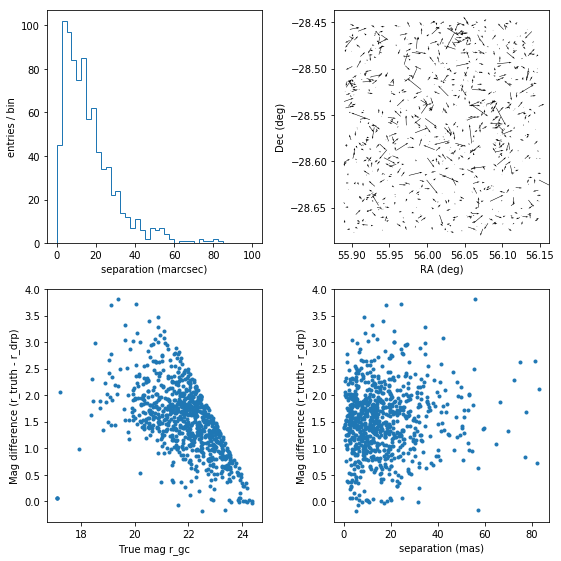

In [18]:
compare_differences(drp_obj_catalog, obj_matches, our_bp)

Number of matches: 587


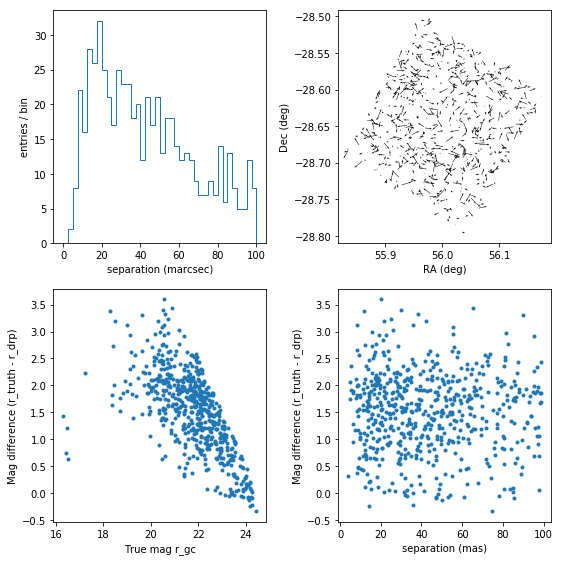

In [19]:
compare_differences(drp_src_catalog, src_matches, our_bp)

For reference, here are the locations of sources/objects in the src/coadd catalogs we built.

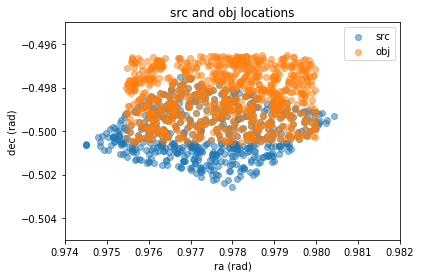

In [20]:
plt.scatter(drp_src_catalog['coord_ra'], drp_src_catalog['coord_dec'], alpha=0.5, label='src')
plt.scatter(drp_obj_catalog['coord_ra'], drp_obj_catalog['coord_dec'], alpha=0.5, label='obj')
plt.title("src and obj locations")
plt.xlabel('ra (rad)')
plt.ylabel('dec (rad)')
plt.xlim([0.974, 0.982])
plt.ylim([-0.505, -0.495])
plt.legend()